# Course Project 4: Image Classifier
## Feature Extraction
As the first task, I will start by extracting **high-level features** from the given images in order to use them for future machine learning models. To achieve this, I will use the **MobileNet V2** convolutional net which extracts 1280 high-level features off of every image.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub # we will load our pre-trained models from there
from PIL import Image 
import matplotlib.pyplot as plt
%matplotlib inline

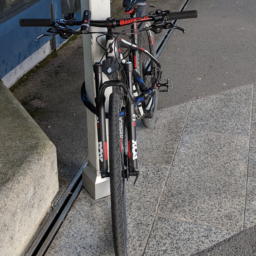

In [2]:
# view an exemplary image
ex_img = Image.open("/Users/Ingo/Python Files/Course-project4/swissroads/train/bike/bike-0001.png")
ex_img

In [3]:
# convert the image to array
ex_img_array = np.array(ex_img)
print("max pixel intensity:", ex_img_array.max())

# get dimensions of the picture
print("dimension of image: first = {}, second = {}".format(len(ex_img_array[0, :, :]),
                                                          len(ex_img_array[:, 0, :])))

max pixel intensity: 255
dimension of image: first = 256, second = 256


As I will use the **MobileNet V2** network, the images need to be resized to **224x224**. Furthermore, I will normalize the pixel intensity to be between 0 and 1.

### Read images from disk with an iterator
To get the high-level features of every image in the train, validation, and test set, I'll build an iterator that iterates over the **swissroads** directory and reads all images

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255, # normalize values between 0 and 1
                                    validation_split = 0, # no split as we have a separate validation set
                                    # no other flips or rotations
                                    )
valid_generator = ImageDataGenerator(rescale = 1/255) # normalize values between 0 and 1

test_generator = ImageDataGenerator(rescale = 1/255) # normalize values between 0 and 1

# create the sets with flow_from_directory function
# no need to standardize batch size as there aren't too many pictures available

# train set
trainset = train_generator.flow_from_directory(
    directory = "/Users/Ingo/Python Files/Course-project4/swissroads/train", target_size = (224, 224),
    shuffle = False, # no need to shuffle as we aren't training a model here
    class_mode = "sparse") # get integer encoded results, not one-hot-encoded results

validset = valid_generator.flow_from_directory(
    directory = "/Users/Ingo/Python Files/Course-project4/swissroads/valid", target_size = (224, 224),
    shuffle = False, class_mode = "sparse")

testset = test_generator.flow_from_directory(
    directory = "/Users/Ingo/Python Files/Course-project4/swissroads/test", target_size = (224, 224),
    shuffle = False, class_mode = "sparse")

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


It seems like the results are correct because manually checking the sets, there are indeed 6 categories available:
* bike
* car
* motorcycle
* other
* truck
* van

Let's check whether any of the sets intersect

In [5]:
set(trainset.filenames).intersection(set(testset.filenames))

set()

In [6]:
set(trainset.filenames).intersection(set(validset.filenames))

set()

In [7]:
set(testset.filenames).intersection(set(validset.filenames))

set()

As all sets are empty, it means that there aren't any intersections among the three sets
___

For the k-NN exercise, we will need the filenames of the testset and of the trainingset, so we will print them here for the sake of convenience

In [8]:
# print testset filename of image 21
testset.filenames[44]

'truck/truck-0070.png'

In [9]:
# get filenames of images 208, 184, 220, 205, 214, 210, 201, 207, 221, 213 of trainset
for filename in [208, 184, 220, 205, 214, 210, 201, 207, 221, 213]:
    print(trainset.filenames[filename])

other/other-0028.png
other/other-0004.png
truck/truck-0008.png
other/other-0025.png
truck/truck-0002.png
other/other-0030.png
other/other-0021.png
other/other-0027.png
truck/truck-0009.png
truck/truck-0001.png


___
We can now iterate over the generators with the next() function

In [10]:
# we can iterate over the generators with the next function
batch_imgs, batch_labels = trainset.next()

# get shapes
print("batch_imgs shape:", batch_imgs.shape)
print("batch_labels shape:", batch_labels.shape)

batch_imgs shape: (32, 224, 224, 3)
batch_labels shape: (32,)


We can see that our images batch has 32 images (32 "rows"), each with size 224 by 224, and 3 (--> R, G, B) channels. The batches have now the necessary 4-dimensional size to be used as input in the models.

The batch labels also have 32 images per batch and are encoded from 0 to 5 in order to reflect the 6 possible categories

In [11]:
len(batch_labels)

32

In [12]:
batch_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In the example batch above, all images belong to the first class, i.e. 0, which denotes bikes as the bikes file was the first to read in.

We can also get the `batch_labels` that `flow_from_directory` read from our files.

In [13]:
trainset.class_indices

{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}

### Import a pre-trained model
We will now import the weights of the **MobileNet V2** model from the TensorFlow Hub to be able to run the `batch_imgs` inside the model and receive high-level 1280 high-level features per image as a result

In [14]:
# create a graph
img_graph = tf.Graph()

with img_graph.as_default():
    # download the model
    module_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2"
    feature_extractor = hub.Module(module_url)
    
    # create input placeholder
    input_imgs = tf.placeholder(dtype = tf.float32, shape = [None, 224, 224, 3]) # input shape is fixed
    
    # create a node with features
    input_features = feature_extractor(input_imgs)
    
    # collect initializers
    init_op = tf.group([
        tf.global_variables_initializer(),
        tf.tables_initializer(), # needed because we import a pre-trained model
    ])
    
# finalize model, from now on "read-only" mode
img_graph.finalize()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [15]:
# test iteration through trainset generator
iteration = 0
while iteration < len(trainset): # len(trainset) --> how many batches are in trainset
    X_batch, y_batch = trainset.next()
    print(X_batch.shape)
    iteration += 1

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(24, 224, 224, 3)
(32, 224, 224, 3)


Here, we have iterated through all 280 train set images. $8* 32 + 24 = 280$ images

In [16]:
# run the session to get all high-level features from all images in train set

with tf.Session(graph = img_graph) as sess:
    # save all extracted high-level train features
    hl_tr_features_list = []
    
    # save corresponding labels in same order for future reference
    tr_labels_list = []
    
    # run init_op
    sess.run(init_op)
    
    # set starting point for iteration
    iteration = 0
    
    # use loop from cell above to iterate through batches
    while iteration < len(trainset):
        X_batch, y_batch = trainset.next()
        
        # extract features
        extracted_features = sess.run(input_features, feed_dict = {
            input_imgs: X_batch
        })
        
        # append features and labels
        hl_tr_features_list.append(extracted_features)
        tr_labels_list.append(y_batch)
        
        # increase iteration +1
        iteration += 1

As the results form `X_batch` are 2-dimensional, we now need to flatten down the list one dimension as the current `hl_tr_features` are now list of lists, i.e. the current length of the list is 9 because there were 9 batches in the for loop

In [17]:
# show that length of feature list is now 9
print("shape of features before flattening", len(hl_tr_features_list))
print("shape of labels before flattening", len(tr_labels_list))

# flatten the feature list with list comprehension
hl_tr_features_list = [extracted_batch for batch in hl_tr_features_list for extracted_batch in batch]
hl_tr_features = np.array(hl_tr_features_list, dtype = np.float32)
print("shapes of features after flattening:", hl_tr_features.shape)

# flatten the labels list
tr_labels_list = [extracted_labels for labels in tr_labels_list for extracted_labels in labels]
tr_labels = np.array(tr_labels_list, dtype = np.int)
print("shape of labels after flattening:", tr_labels.shape)

shape of features before flattening 9
shape of labels before flattening 9
shapes of features after flattening: (280, 1280)
shape of labels after flattening: (280,)


Now we have the expected shapes: 280 rows for the 280 different training images, and the corresponding 1280 extracted high-level features from every image.

The labels also have the 280 rows.

Now we can save these arrays in an `.npz` file to be able to import them later on

In [18]:
# save the two arrays in .npz file
np.savez("high-level-train-features.npz", features = hl_tr_features, labels = tr_labels)

Now we can repeat the high-level feature extraction for the validation and test set, flatten down the one dimension, and save them in `.npz` files, too.

In [19]:
# extract high-level features of validation set
with tf.Session(graph = img_graph) as sess:
    # run initialization 
    sess.run(init_op)
    
    # save results
    hl_valid_features_list = []
    valid_labels_list = []
    
    # start iteration at 0
    iteration = 0
    
    # run feature extraction
    while iteration < len(validset):
        X_batch, y_batch = validset.next()
        
        extracted_features = sess.run(input_features, feed_dict = {
            input_imgs: X_batch
        })
        
        # append results
        hl_valid_features_list.append(extracted_features)
        valid_labels_list.append(y_batch)
        
        # increase iteration +1
        iteration += 1
        
# flatten the list one dimension
hl_valid_features_list = [extracted_features
                          for batch in hl_valid_features_list for extracted_features in batch]
valid_labels_list = [extracted_labels for batch in valid_labels_list for extracted_labels in batch]

# convert lists to arrays
hl_valid_features = np.array(hl_valid_features_list)
valid_labels = np.array(valid_labels_list)

# get shapes
print("shape of extracted validset features:", hl_valid_features.shape)
print("shape of corresponding labels:", valid_labels.shape)

shape of extracted validset features: (139, 1280)
shape of corresponding labels: (139,)


In [20]:
# save the high-level validset features
np.savez("high-level-valid-features.npz", features = hl_valid_features, labels = valid_labels)

In [21]:
# extract test features
with tf.Session(graph = img_graph) as sess:
    # run initialization
    sess.run(init_op)
    
    # save results
    hl_te_features_list = []
    te_labels_list = []
    
    # start iteration at 0
    iteration = 0
    
    # run loop to iterate through batches
    while iteration < len(testset):
        X_batch, y_batch = testset.next()
        
        # extract features
        extracted_features = sess.run(input_features, feed_dict = {
            input_imgs: X_batch
        })
        
        # append results
        hl_te_features_list.append(extracted_features)
        te_labels_list.append(y_batch)
        
        # increate iteration +1
        iteration += 1
        
# flatten list one dimension
hl_te_features_list = [extracted_features for batch in hl_te_features_list for extracted_features in batch]
te_labels_list = [extracted_labels for batch in te_labels_list for extracted_labels in batch]

# convert lists to array
hl_te_features = np.array(hl_te_features_list)
te_labels = np.array(te_labels_list)

# check shapes
print("extracted features shape:", hl_te_features.shape)
print("labels shape:", te_labels.shape)

extracted features shape: (50, 1280)
labels shape: (50,)


In [22]:
# save high-level extracted test features
np.savez("high-level-test-features.npz", features = hl_te_features, labels = te_labels)